# **Download Data from kaggle**
dont forget to add the kaggle API to the environtment

In [1]:
pip install -q kaggle

In [2]:
mkdir ~/.kaggle

In [3]:
cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
 ! kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  
vishnuvarthanrao/windows-store                              Windows Store                                     93KB  2020-07-07 12:29:07           1034  
vzrenggamani/hanacaraka                                     Aksara Jawa / Hanacaraka                           9MB  2020-07-10 15:09:31             62  
rohanrao/chai-time-data-science                             Chai Time Data Science | CTDS.Show                 3MB  2020-07-23 17:23:46            708  
garystafford/environmental-sensor-data-132k                 Environmental Sensor Telemetry Data                7MB  2020-07-20 17:18:10            269  
moezabid/zillow-all-homes-data                              Zillow All Homes Data 

In [6]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 19.6MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.4MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 132MB/s]


#**Downloading pre-trained fastText, preparing datasets, and pre-processing**

In [7]:
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [9]:
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

2010it [00:00, 10336.28it/s]

loading word embeddings...


999995it [01:49, 9122.39it/s]

found 999995 word vectors


In [10]:
#load data
train_df = pd.read_csv('train.csv', sep=',', header=0)
test_df = pd.read_csv('test.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])

num train:  7613
num test:  3263


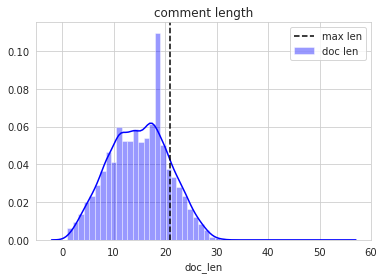

In [11]:
label_names = ["target"]
y_train = train_df[label_names].values
train_df['doc_len'] = train_df['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [12]:
raw_docs_train = train_df['text'].tolist()
raw_docs_test = test_df['text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  6%|▌         | 453/7613 [00:00<00:01, 4526.43it/s]

pre-processing train data...


100%|██████████| 3263/3263 [00:00<00:00, 4599.17it/s]


tokenizing input data...
dictionary size:  28717


#**Shape and Train with LSTM**

In [13]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [14]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 14247


In [15]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['bftiapf35f' '2qjl5mfkzv' 'foragesecret' 'fl8gci84aj' 'boua80z5wf'
 'werk9qibvv' 'tpoptwmwfr' 'izjk6kpwiz' 'rpbxdfnx5k' 'cubdnsnuvt']


In [25]:
from keras.layers import BatchNormalization
import tensorflow as tf
model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 300)           8615400   
_________________________________________________________________
dropout (Dropout)            (None, 21, 300)           0         
_________________________________________________________________
dense (Dense)                (None, 21, 32)            9632      
_________________________________________________________________
bidirectional (Bidirectional (None, 21, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [26]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=True)

Epoch 1/40
21/21 [==============================] - 4s 189ms/step - loss: 0.2644 - accuracy: 0.8921 - val_loss: 0.4263 - val_accuracy: 0.8179
Epoch 2/40
21/21 [==============================] - 4s 191ms/step - loss: 0.2629 - accuracy: 0.8957 - val_loss: 0.4266 - val_accuracy: 0.8253
Epoch 3/40
21/21 [==============================] - 4s 188ms/step - loss: 0.2613 - accuracy: 0.8996 - val_loss: 0.4367 - val_accuracy: 0.8148
Epoch 4/40
21/21 [==============================] - 4s 193ms/step - loss: 0.2633 - accuracy: 0.8940 - val_loss: 0.4325 - val_accuracy: 0.8222


In [51]:
#incase you wanna try again
#keras.backend.clear_session()

#**Evaluation**

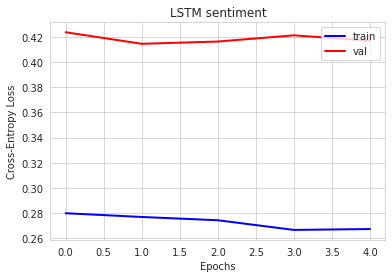

In [53]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

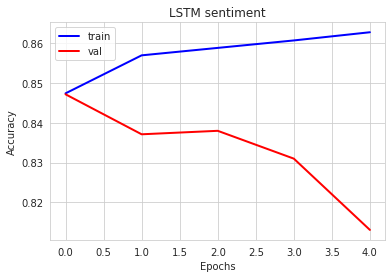

In [45]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [55]:
predictions= model.predict_classes(word_seq_test)

In [56]:
sample=pd.read_csv('sample_submission.csv')
sample['target']= (predictions>0.5).astype(int)
sample.to_csv("submission.csv",index=False, header=True)

In [57]:
sample.head(20)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [58]:
#!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Using LSTM with fastText Word-Embedding"

100% 22.2k/22.2k [00:00<00:00, 138kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets